Logs:   
[2023/09/05] 
- Implementation of AR(p) in `from statsmodels.tsa.arima_model import ARMA, ARIMA`.    
  is deprecated. Use SARIMAX.


To do:
- Update `rolling_forecast` (see `week-04.ipynb`)

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error


In [58]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})


**Function declarations**

In [59]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_date_locator:
    formatter = mdates.DateFormatter("%Y")
    locator = mdates.YearLocator(base=2)
    # locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
  

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_date_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

  plt.show(fig)



## 5.1 Predicting the average weekly foot traffic in a retail store

Suppose that you want to forecast the average weekly foot traffic in 
a retail store so that the store manager can better manage the staff's schedule.
Note that this is fictional data.

In [60]:
file_path = "./datasets/foot_traffic_with_date.csv"
df_foot_traffic = pd.read_csv(file_path, parse_dates=[0])
# df_foot_traffic = pd.read_csv(file_path)
# df_foot_traffic["foot_traffic"] = df_foot_traffic["foot_traffic"].astype(int)
df_foot_traffic

,date,foot_traffic
0,2000-01-02,500.496714
1,2000-01-09,500.522366
2,2000-01-16,501.426876
3,2000-01-23,503.295990
4,2000-01-30,504.132695
...,...,...
995,2019-01-27,706.009031
996,2019-02-03,705.610549
997,2019-02-10,704.771335
998,2019-02-17,703.559920


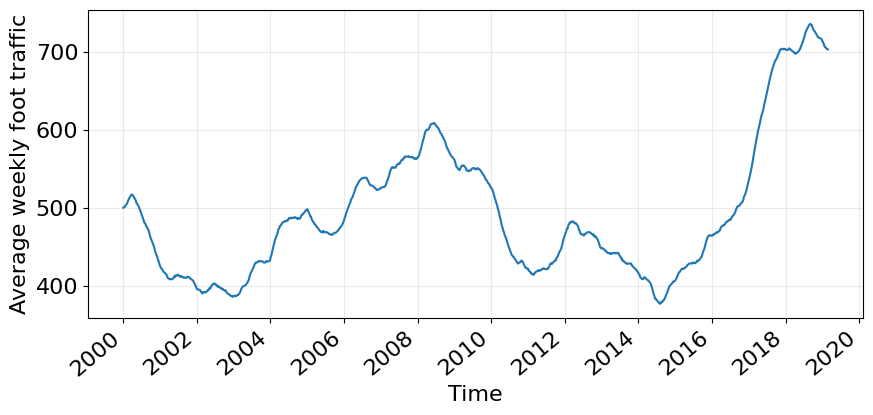

In [61]:
plot_time_series(df_foot_traffic["date"], df_foot_traffic["foot_traffic"],  
  "Time", "Average weekly foot traffic")

## 5.2 Defining the autoregressive process

**Autoregressive process**    
An autoregressive process is a regression of a variable against itself.    
In a time series, this means that the present value is linearly dependent
on its past values.   

The autoregressive process is denoted as $\text{AR(p)}$, where $p$ is the order.   
The general expression of an $\text{AR}(p)$ model is
$$
  y_t = C + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \ldots + \phi_p y_{t-p} + \epsilon_t
$$

The random walk process is a special case of an autoregressive process,
where the order $p = 1$, and $\phi_1 = 1$.

## 5.3 Finding the order of a stationary autoregressive process

An extension step-by-step from the previous steps when deciding
the model of $\text{MA}(q)$.

<img src="./figures/identify-stationary-order-ma-order-ar.drawio.png" width=1000>

The next step is to check stationary

In [62]:
ADF_result = adfuller(df_foot_traffic['foot_traffic'])

print(f"ADF statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF statistic: -1.1758885999240758
p-value: 0.6838808917896185


Since the ADF statistic is not a large negative number, and
it has a $p$-value greater than 0.05, we cannot reject the 
null hypothesis and our series is therefore non-stationary

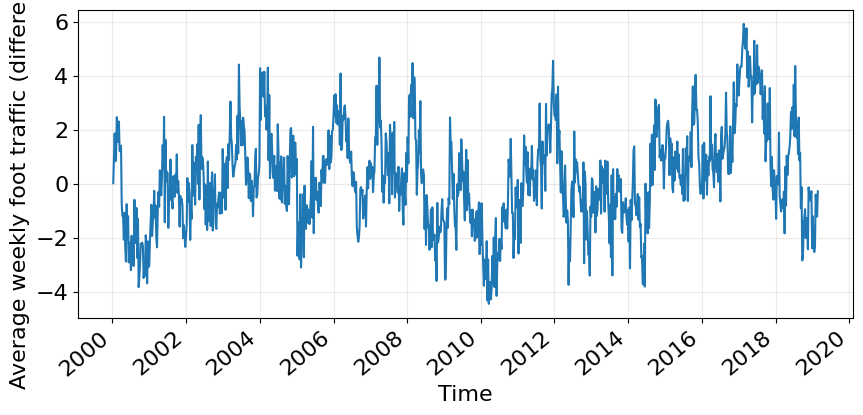

In [63]:
foot_traffic_diff = np.diff(df_foot_traffic["foot_traffic"], n=1)

plot_time_series(df_foot_traffic["date"].iloc[1:], foot_traffic_diff, 
                 ylabel="Average weekly foot traffic (differenced)")

With a transformation applied to the series, we can verify whether
the series is stationary by running the ADF test on the differenced series.

In [64]:
ADF_diff_result = adfuller(foot_traffic_diff)

print(f"ADF statistic: {ADF_diff_result[0]}")
print(f"p-value: {ADF_diff_result[1]}")

ADF statistic: -5.268231347422051
p-value: 6.369317654781036e-06


With a $p$-value smaller than $0.05$, we can reject the null hypothesis,
meaning that we now have a stationary series.

The next step is to plot the ACF and see if there is autocorrelation
and if the coefficients become abruptly non-significant after a certain
lag.

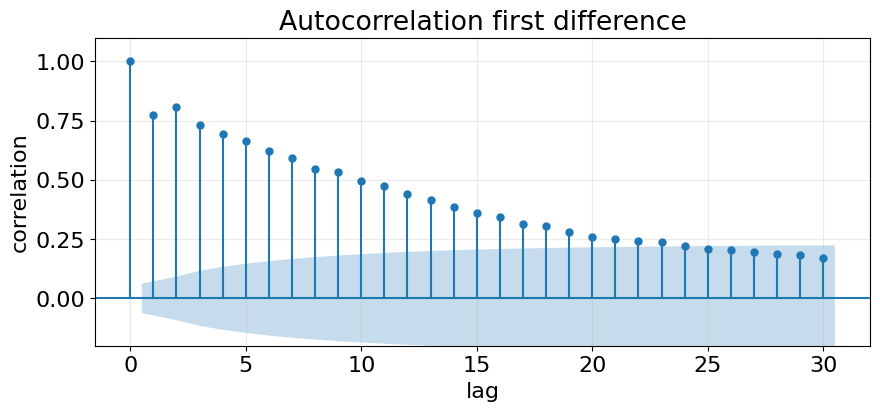

In [65]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(foot_traffic_diff, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation first difference")
ax.grid("on")

plt.show(fig)

In the above plot, there is no lag at which the coefficients abruptly
become non-significant. We clearly see that the coefficients are 
decaying exponentially as the lag increase.   
This means that we do not have a moving average
process and that we are likely studying an autoregressive process.

See the text for the motivation of partial autocorrelation.

**Partial autocorrelation**    
Partial autocorrelation measures the correlation between lagged values
in a time series when we remove the influence of correlated lagged values
in between. We can plot the partial autocorrelation functon to determine
the order of a stationary $\text{AR}(p)$ process. The coefficients
will be non-significant after lag $p$.

Before we continue finding the order $\text{AR}(p)$ for the given series,
let us verify PACF plot by generating $\text{AR}(2)$ process.

Our $\text{AR}(2)$ model is governed by the following equation:
$$
  y_t = 0.33 y_{t-1} + 0.50 y_{t-2} 
$$
Then using that equation, we generate $1,000$ samples

In [66]:
seed = 20230911 
rng = np.random.default_rng(seed)
distrvs = lambda size: rng.standard_normal(size)

ma2_coeff = np.array([1, 0, 0])
ar2_coeff = np.array([1, -0.33, -0.50])   # 1.*yt - .33*yt-1 - .55*yt-2

ar2_process = ArmaProcess(ar2_coeff, ma2_coeff)\
    .generate_sample(nsample=1000, distrvs=distrvs)

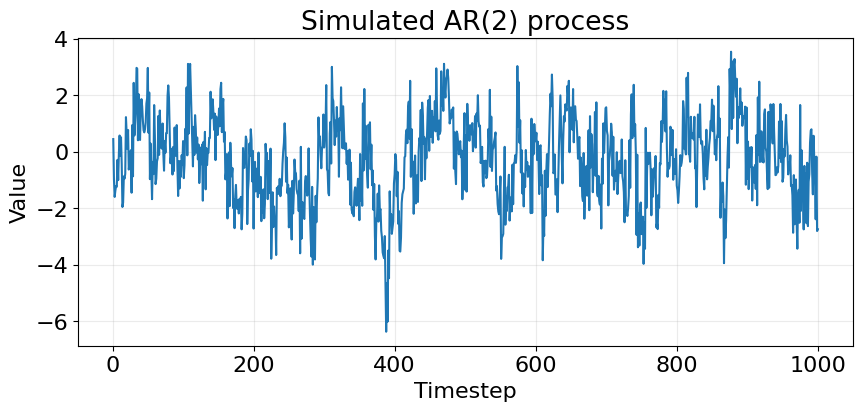

In [67]:
plot_time_series(np.arange(1, 1001), ar2_process, 
                 ylabel="Value", xlabel="Timestep", use_date_locator=False, 
                 title="Simulated AR(2) process")

Let us plot the PACF and see if the coefficients become abruptly non-significant after lag 2.

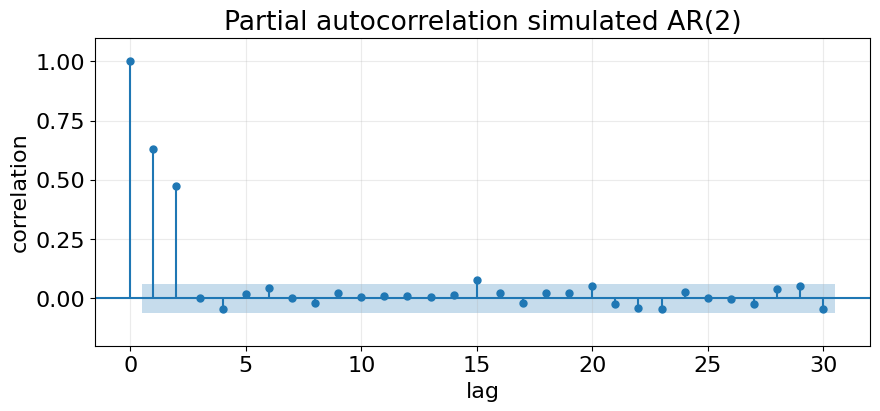

In [68]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_pacf(ar2_process, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Partial autocorrelation simulated AR(2)")
ax.grid("on")

plt.show(fig)

The resulting plot is shown that we have an autoregressive process of order 2.

Let us see if we can apply the same strategy to our average weekly foot 
traffic dataset

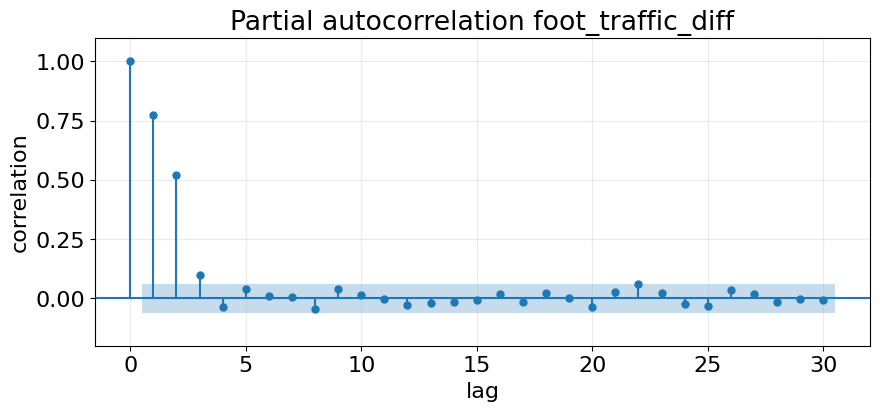

In [69]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_pacf(foot_traffic_diff, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Partial autocorrelation foot_traffic_diff")
ax.grid("on")

plt.show(fig)


Looking at the plot above, we can see that there are no significant coefficients
after lag 3.    
Therefore, the differenced average weekly foot traffic is
an autoregressive process of order 3, which can be denoted as $\text{AR}(3)$

## 5.4 Forecasting an autoregressive process

We hold the last 52 weeks of data for our test set, while the rest will be
used for training.

In [70]:
df_foot_traffic_diff = pd.DataFrame({
    "date": df_foot_traffic["date"][1:],
    "foot_traffic_diff": foot_traffic_diff })

df_train = df_foot_traffic_diff[:-52]
df_test = df_foot_traffic_diff[-52:]

print(f"(len(train), len(test)): ({len(df_train), len(df_test)})")

(len(train), len(test)): ((947, 52))


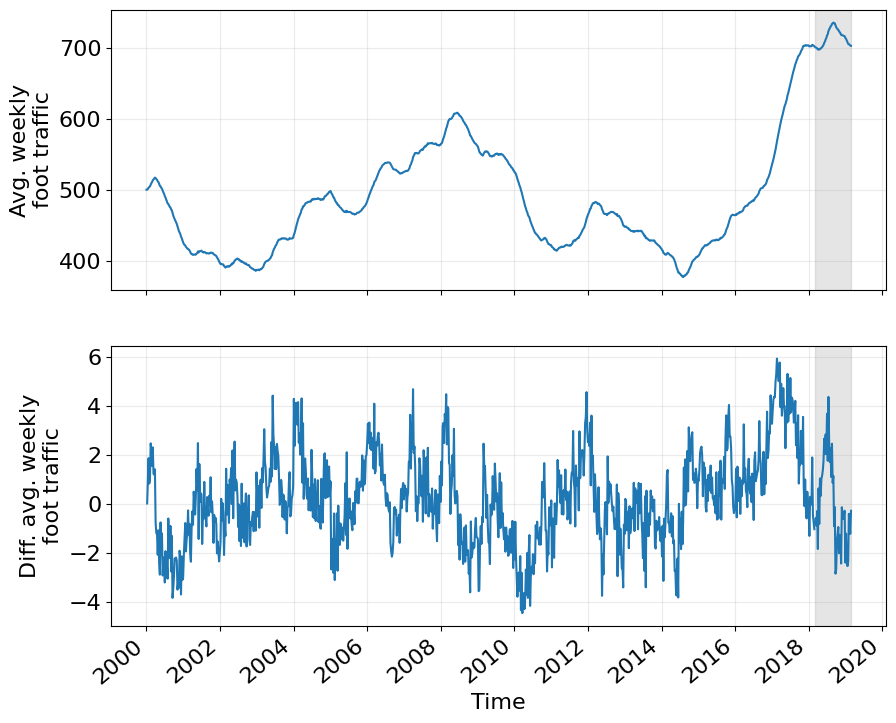

In [71]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

axes[0].plot(df_foot_traffic['date'], df_foot_traffic["foot_traffic"])

axes[0].grid("on")
axes[0].set_ylabel("Avg. weekly\nfoot traffic")

# -- second row
axes[1].plot(df_train["date"], df_train["foot_traffic_diff"])
axes[1].plot(df_test["date"], df_test["foot_traffic_diff"], color="tab:blue")

formatter = mdates.DateFormatter("%Y")
locator = mdates.YearLocator(base=2)
# locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("Diff. avg. weekly\nfoot traffic")
axes[1].grid("on")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['date'].iloc[0], df_test['date'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

plt.show(fig)




In [84]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, 
                      method: str) -> list:
  """
  The following models using all the dataframe (train + test),
  because we roll out forecast with a correct data with the length
  of forecast is equal to `horizon`
  """
  total_len = train_len + horizon

  if method == "mean":
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i]["foot_traffic_diff"])
      pred_mean.extend(mean for _ in range(window))

    return pred_mean

  elif method == "last":
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i]["foot_traffic_diff"].iloc[-1]
      pred_last_value.extend(last_value for _ in range(window))

    return pred_last_value

  elif method == "AR":
    pred_AR = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i]["foot_traffic_diff"], order=(3, 0, 0))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_AR.extend(oos_pred)

    return pred_AR


In [88]:
pred_df = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)
WINDOW = 3

pred_mean = rolling_forecast(df_foot_traffic_diff, TRAIN_LEN, HORIZON, WINDOW, "mean")
pred_last_value = rolling_forecast(df_foot_traffic_diff, TRAIN_LEN, HORIZON, WINDOW, "last")
pred_AR = rolling_forecast(df_foot_traffic_diff, TRAIN_LEN, HORIZON, WINDOW, "AR")

print(pred_mean)
# pred_df["pred_mean"].iloc[:-1] = pred_mean
pred_df["pred_last_value"] = pred_last_value
pred_df["pred_AR"] = pred_AR

pred_df.head()
# pred_df


[0.21327002741249707, 0.21327002741249707, 0.21327002741249707, 0.21023661751377953, 0.21023661751377953, 0.21023661751377953, 0.20802315137749905, 0.20802315137749905, 0.20802315137749905, 0.20795560498314852, 0.20795560498314852, 0.20795560498314852, 0.21099239545862913, 0.21099239545862913, 0.21099239545862913, 0.21702915792796754, 0.21702915792796754, 0.21702915792796754, 0.22523076677540324, 0.22523076677540324, 0.22523076677540324, 0.23348474964158028, 0.23348474964158028, 0.23348474964158028, 0.23799776818797433, 0.23799776818797433, 0.23799776818797433, 0.24185690664396073, 0.24185690664396073, 0.24185690664396073, 0.2371666900091038, 0.2371666900091038, 0.2371666900091038, 0.23091178012518426, 0.23091178012518426, 0.23091178012518426, 0.22592882899759853, 0.22592882899759853, 0.22592882899759853, 0.2211449855933012, 0.2211449855933012, 0.2211449855933012, 0.21893904823842622, 0.21893904823842622, 0.21893904823842622, 0.21438648548746056, 0.21438648548746056, 0.2143864854874605

ValueError: Length of values (54) does not match length of index (52)

In [75]:
pred_df.count()

date                 52
foot_traffic_diff    52
pred_mean            52
pred_last_value      52
pred_AR              52
dtype: int64

Now we can visualize our predictions agains the observed values in the test set.

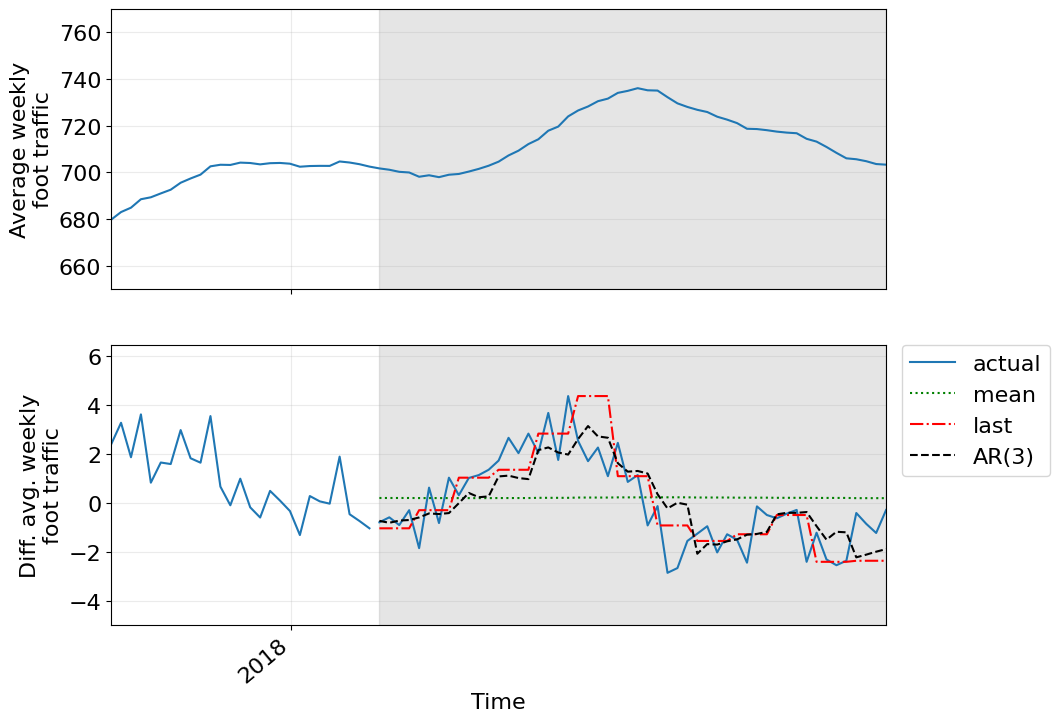

In [76]:
xlim = [df_train["date"].iloc[920], df_test["date"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

axes[0].set_ylim([650, 770])

# -- second row
axes[1].plot(df_train["date"], df_train["foot_traffic_diff"])
axes[1].plot(df_test["date"], df_test["foot_traffic_diff"], color="tab:blue", label="actual")

formatter = mdates.DateFormatter("%Y")
locator = mdates.YearLocator(base=2)
# locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("Diff. avg. weekly\nfoot traffic")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["date"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["date"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["date"], pred_df["pred_AR"], "k--", label="AR(3)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['date'].iloc[0], df_test['date'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_foot_traffic['date'], df_foot_traffic["foot_traffic"])

axes[0].grid("on")
axes[0].set_ylabel("Average weekly\nfoot traffic")
axes[0].set_xlim(xlim)


plt.show(fig)




Measuring the performance of our models by computing MSE.


In [77]:
mse_mean = mean_squared_error(pred_df["foot_traffic_diff"], pred_df["pred_mean"])
mse_last = mean_squared_error(pred_df["foot_traffic_diff"], pred_df["pred_last_value"])
mse_AR = mean_squared_error(pred_df["foot_traffic_diff"], pred_df["pred_AR"])

print(f"MSE mean: {mse_mean}")
print(f"MSE last: {mse_last}")
print(f"MSE AR: {mse_AR}")


MSE mean: 3.115076796154647
MSE last: 1.458958409747375
MSE AR: 1.3361980355041834


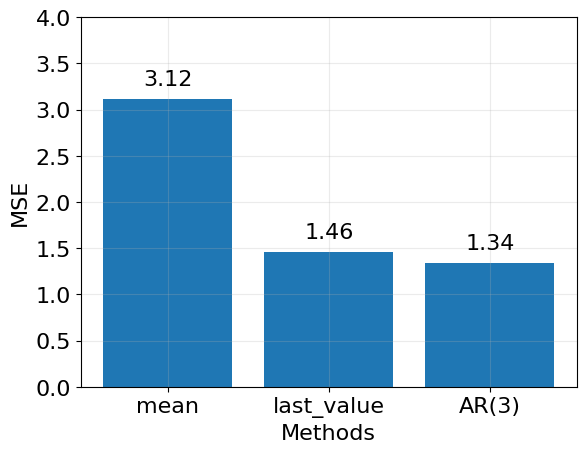

In [78]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "AR(3)"]
y_array = [mse_mean, mse_last, mse_AR]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 4])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.15, s=f"{val:.2f}", ha="center")

plt.show(fig)

Now we recover by inverse tranform of our prediction to bring them
back  to the original scale.

$$
\begin{align*}
  y'_1 = y_1 - y_0 \quad &\Rightarrow y_1 = y_0 + y'_1 \\
  y'_2 = y_2 - y_1 \quad &\Rightarrow y_2 = y_1 + y'_2 = (y_0 + y'_1) + y'_2 \\
  y'_3 = y_3 - y_2 \quad &\Rightarrow y_3 = y_2 + y'_3 = (y_1 + y'_2) + y'_3 = ((y_0 + y'_1) + y'_2) + y'_3 \\
  \vdots \\
  y'_N = y_N - y_{N-1} \quad &\Rightarrow 
    y_N = y_{N-1} + y'_N = (y_{N-2} + y'_{N-1}) + y'_N = \ldots 
        = y_0 + \sum_{t=1}^{N} y'_t
\end{align*}
$$


In [79]:
idx_y0 = len(df_train) + 1 
y0 = df_foot_traffic.iloc[idx_y0]["foot_traffic"]
# print(y0)
test_df_foot_traffic = df_foot_traffic[idx_y0:].copy()
test_df_foot_traffic["pred_mean"] = y0 + pred_df["pred_mean"].cumsum()
test_df_foot_traffic["pred_last_value"] = y0 + pred_df["pred_last_value"].cumsum()
test_df_foot_traffic["pred_AR"] = y0 + pred_df["pred_AR"].cumsum()
test_df_foot_traffic.head()


,date,foot_traffic,pred_mean,pred_last_value,pred_AR
948,2018-03-04,701.686830,701.900100,700.664937,700.967116
949,2018-03-11,701.112198,702.113370,699.643044,700.170591
950,2018-03-18,700.221501,702.326640,698.621152,699.462878
951,2018-03-25,699.937948,702.539910,697.599259,698.778927
952,2018-04-01,698.107264,702.749627,697.315707,698.199648


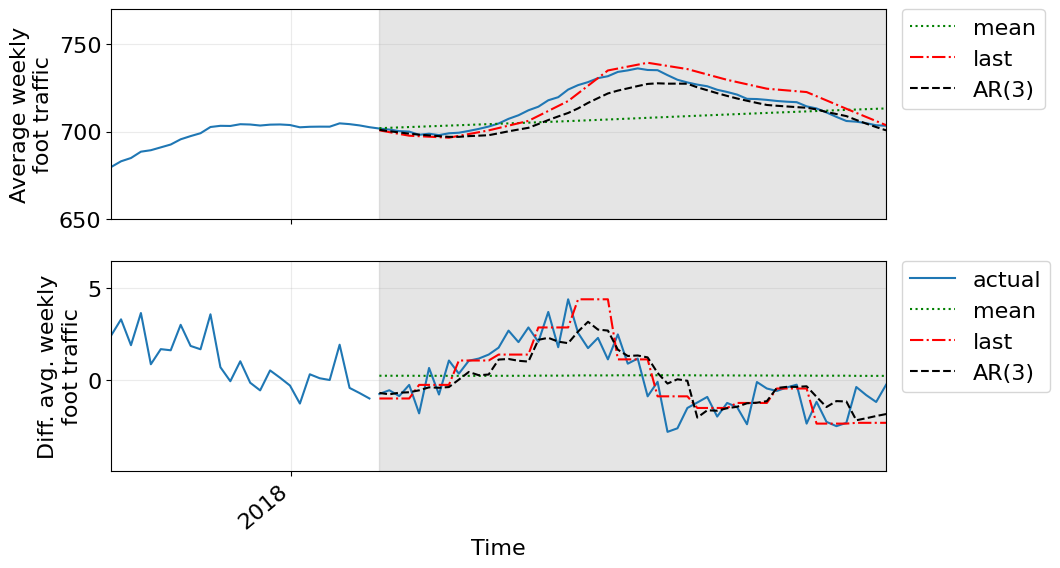

In [80]:
xlim = [df_train["date"].iloc[920], df_test["date"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

axes[0].set_ylim([650, 770])

# -- second row
axes[1].plot(df_train["date"], df_train["foot_traffic_diff"])
axes[1].plot(df_test["date"], df_test["foot_traffic_diff"], color="tab:blue", label="actual")

formatter = mdates.DateFormatter("%Y")
locator = mdates.YearLocator(base=2)
# locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("Diff. avg. weekly\nfoot traffic")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["date"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["date"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["date"], pred_df["pred_AR"], "k--", label="AR(3)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['date'].iloc[0], df_test['date'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_foot_traffic['date'], df_foot_traffic["foot_traffic"])

# -- prediction for the original data
axes[0].plot(test_df_foot_traffic['date'], test_df_foot_traffic["pred_mean"], "g:", label="mean")
axes[0].plot(test_df_foot_traffic['date'], test_df_foot_traffic["pred_last_value"], "r-.", label="last")
axes[0].plot(test_df_foot_traffic['date'], test_df_foot_traffic["pred_AR"], "k--", label="AR(3)")

axes[0].grid("on")
axes[0].set_ylabel("Average weekly\nfoot traffic")
axes[0].set_xlim(xlim)
axes[0].set_ylim()
axes[0].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)




Measure mean absolute error of the original data


In [81]:
mae_mean_undiff = mean_absolute_error(test_df_foot_traffic["foot_traffic"], test_df_foot_traffic["pred_mean"])
mae_last_undiff = mean_absolute_error(test_df_foot_traffic["foot_traffic"], test_df_foot_traffic["pred_last_value"])
mae_AR_undiff   = mean_absolute_error(test_df_foot_traffic["foot_traffic"], test_df_foot_traffic["pred_AR"])

print(f"MAE mean: {mae_mean_undiff}")
print(f"MAE last: {mae_last_undiff}")
print(f"MAE AR: {mae_AR_undiff}")

MAE mean: 10.782437719126083
MAE last: 4.382478239419299
MAE AR: 4.506278640474552


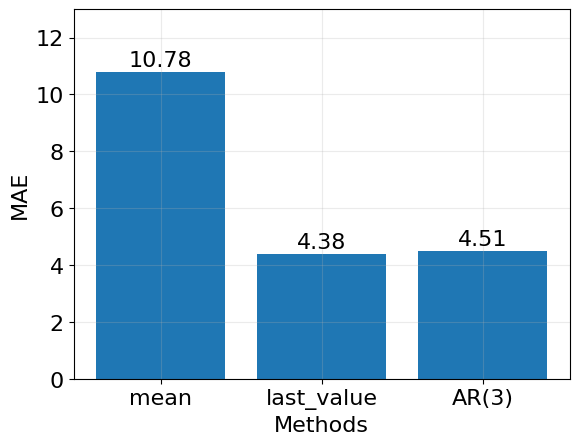

In [82]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "AR(3)"]
y_array = [mae_mean_undiff, mae_last_undiff, mae_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 13])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

## 5.5 Next steps

ARMA process, or $\text{ARMA}(p, q)$

When both the ACF and PACF plot exhibit a slow decay
or a sinusoidal pattern.

## Fix some bugs in data

Add date to `foot_traffic.csv`. Frequency of the time is weekly.

In [83]:
file_path = "./datasets/foot_traffic.csv"
df_foot_traffic_with_date = pd.read_csv(file_path)

df_foot_traffic_with_date["date"] \
  = pd.date_range(start="2000-01-01", periods=len(df_foot_traffic_with_date), freq="W")
df_foot_traffic_with_date = df_foot_traffic_with_date[["date", "foot_traffic"]]

df_foot_traffic_with_date.to_csv("./datasets/foot_traffic_with_date.csv", index=False)

df_foot_traffic_with_date



,date,foot_traffic
0,2000-01-02,500.496714
1,2000-01-09,500.522366
2,2000-01-16,501.426876
3,2000-01-23,503.295990
4,2000-01-30,504.132695
...,...,...
995,2019-01-27,706.009031
996,2019-02-03,705.610549
997,2019-02-10,704.771335
998,2019-02-17,703.559920
